In [2]:
# 📦 Imports and Configuration

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm




In [3]:
# ➤ Paths for hyperparameter search: tuning runs, logs, results

# ----------------------------
# Device setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🛠 Device: {device}")

DATA_PATH = "/kaggle/input/windloading-train/WindLoading_Train.csv"
SAVE_ROOT = "/kaggle/working"

# DATA_PATH = "/mnt/d/projects/wind_fluctuation_prediction_2025/data/processed/windloading_train.csv"
# SAVE_ROOT = "/mnt/d/projects/wind_fluctuation_prediction_2025/experiments"

TUNING_DIR = os.path.join(SAVE_ROOT, "tuning_mlp")
LOG_CSV_PATH = os.path.join(SAVE_ROOT, "experiments_log.csv")

os.makedirs(TUNING_DIR, exist_ok=True)

# ➤ Function to create a run-specific directory
def create_run_directory(hidden_dim, lr, batch_size=64, epochs=500, activation_fn=None, optimizer_name=None, base_dir=TUNING_DIR):
    run_id = f"mlp_{hidden_dim}h_{lr:.0e}lr_{batch_size}bs_{epochs}ep"

    # 👇 Добавим активацию в имя, если она передана
    if activation_fn is not None:
        run_id += f"_{activation_fn.__name__}"

    # 👇 Добавим имя оптимизатора в имя, если оно передано
    if optimizer_name is not None:
        run_id += f"_{optimizer_name}"

    run_dir = os.path.join(base_dir, run_id)
    os.makedirs(run_dir, exist_ok=True)
    print(f"📂 Created run directory: {run_dir}")
    return run_id, run_dir

🛠 Device: cuda


In [4]:
# ➤ Function for loading the dataset from CSV

def load_dataset():
    df = pd.read_csv(DATA_PATH)
    print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
    return df

In [5]:
# ➞ Function to compute regression metrics: MSE, MAE, R²

def evaluate_regression(y_true, y_pred):
    y_true_np = y_true.detach().cpu().numpy()
    y_pred_np = y_pred.detach().cpu().numpy()

    # 🔍 Remove NaNs before computing metrics
    mask = ~np.isnan(y_true_np) & ~np.isnan(y_pred_np)
    y_true_np = y_true_np[mask]
    y_pred_np = y_pred_np[mask]

    if len(y_true_np) == 0 or len(y_pred_np) == 0:
        raise ValueError("No valid data points after removing NaNs.")

    mse = mean_squared_error(y_true_np, y_pred_np)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    return {"MSE": mse, "MAE": mae, "R2": r2}


In [6]:
# ➤ Definition of the MLP architecture with customizable activation function

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation_fn):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, hidden_dim),
            activation_fn(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


In [7]:
# ➤ Training function for MLP model: used in Random Search and experiment tracking

def train_mlp(hidden_dim, lr, batch_size, epochs, output_dim=1, activation_fn=nn.ReLU, optimizer_name="Adam"):

    # ----------------------------
    # Ensure CSV file exists and has header
    # ----------------------------
    if not os.path.exists(LOG_CSV_PATH):
        with open(LOG_CSV_PATH, "w") as f:
            f.write("run_id,hidden_dim,lr,batch_size,activation_fn,optimizer_name,R2,MAE,MSE\n")


    # ----------------------------
    # Load dataset
    # ----------------------------
    df = load_dataset()
    X = df[['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang']]
    y = df[['StdDev']]
    input_dim = X.shape[1]

    # 🔍 Проверка первых строк X и y
    print("📄 Features (X):")
    print("\n🎯 Target (y):")
    # display(y.head())

    # 📐 Размерности
    print(f"\n✅ X shape: {X.shape}")
    print(f"✅ y shape: {y.shape}")


    # ----------------------------
    # K-Fold Cross-Validation
    # ----------------------------
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"\n🔁 Fold {fold + 1} / 5")

        # 📊 Разделение данных
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 🔁 Преобразуем в тензоры
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
        X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).to(device)

        batch_X = X_train_tensor
        batch_y = y_train_tensor
        
        '''
        # 📦 DataLoader с правильным порядком
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        '''
        print("X_train.shape =", X_train.shape)


        # 🧠 Создание новой модели на каждый фолд
        model = MLP(input_dim, hidden_dim, output_dim, activation_fn=activation_fn).to(device)
        print("📦 Model is on device:", next(model.parameters()).device)

         # ----------------------------
        # Training loop
        # ----------------------------
        criterion = nn.MSELoss()
        if optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr)
        elif optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(model.parameters(), lr=lr)
        elif optimizer_name == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr)
        else:
            raise ValueError(f"Unknown optimizer: {optimizer_name}")
        train_loss_history = []

        # 🔁 Early Stopping init
        early_stopping_patience = 100
        patience_counter = 0
        best_loss = float('inf') 

        for epoch in tqdm(range(epochs), desc="Epochs"):
            model.train()
            epoch_loss = 0.0

            accumulation_steps = 1  # 🧠 Обновляем веса каждые 1000 батчей
            optimizer.zero_grad()
            epoch_loss = 0.0
                        
            '''
            for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss = loss / accumulation_steps  # 🔁 делим loss, чтобы избежать взрыва градиентов
                loss.backward()
                epoch_loss += loss.item() * accumulation_steps
            
                if (batch_idx + 1) % accumulation_steps != 0:
                    optimizer.step()
                    optimizer.zero_grad()
            '''
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

            '''
            current_loss = epoch_loss / len(train_loader)
            '''
            current_loss = loss.item()
            train_loss_history.append(current_loss)

            # 💡 Early Stopping check (выполняется на каждой эпохе)
            if current_loss < best_loss:
                best_loss = current_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
                if patience_counter >= early_stopping_patience:
                    print(f"⏹️ Early stopping at epoch {epoch+1} — no improvement in {early_stopping_patience} epochs.")
                    break

            # ⏺️ Logging (только раз в 10 эпох)
            if (epoch + 1) % 3000 == 0:
                log_str = f"Epoch [{epoch+1}/{epochs}], Loss: {current_loss:.4f}"
                print(log_str)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_tensor)
            metrics = evaluate_regression(y_val_tensor, y_pred)
            fold_metrics.append(metrics)
            print(f"📈 Fold {fold + 1} metrics: {metrics}")

    # ----------------------------
    # Average metrics across folds
    # ----------------------------
    avg_metrics = {
        "MSE": sum(m["MSE"] for m in fold_metrics) / len(fold_metrics),
        "MAE": sum(m["MAE"] for m in fold_metrics) / len(fold_metrics),
        "R2":  sum(m["R2"]  for m in fold_metrics) / len(fold_metrics),
    }
    
    # ----------------------------
    # Run directory
    # ----------------------------
    run_id, run_dir = create_run_directory(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=epochs,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )

    # ----------------------------
    # Save config
    # ----------------------------
    config = {
        "input_dim": input_dim,
        "hidden_dim": hidden_dim,
        "output_dim": output_dim,
        "lr": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "activation_fn": activation_fn.__name__,
        "optimizer_name": optimizer_name,
        "features": ['X_int', 'Y_int', 'X_fac', 'Y_fac', 'Ang'],
        "targets": ['StdDev']
    }
    config_filename = f"config_{run_id}_ex.json"
    with open(os.path.join(run_dir, config_filename), "w") as f:
        json.dump(config, f, indent=4)

    # ----------------------------
    # Append summary to global CSV log
    # ----------------------------
    with open(LOG_CSV_PATH, "a") as f:
        f.write(f"{run_id},{hidden_dim},{lr:.0e},{batch_size},{activation_fn.__name__},{optimizer_name},{avg_metrics['R2']:.4f},{avg_metrics['MAE']:.4f},{avg_metrics['MSE']:.6f}\n")

    print(f"\n📊 Average metrics across 5 folds:\n{avg_metrics}")
    return run_id, avg_metrics
    



In [10]:
# 📁 src/tuning/random_search_mlp.py
# ➤ Random Search for MLP model: selects hyperparameters and launches training

# 🔧 Hyperparameter options
# hidden_dim_choices = [128]
# hidden_dim_choices = [32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 384]
hidden_dim_choices = [256]

# lr_choices = [0.009]
# lr_choices = [round(lr, 5) for lr in np.arange(0.001, 0.021, 0.001)]
lr_choices = [round(lr, 5) for lr in np.arange(0.003, 0.005, 0.001)]

# batch_size_choices = [64]
# batch_size_choices = [8, 16, 32, 48, 64, 96, 128]
batch_size_choices = [32]


activation_choices = [nn.Tanh]
# activation_choices = [nn.ReLU, nn.LeakyReLU, nn.Tanh]
optimizer_choices = ["Adam"]
# optimizer_choices = ["Adam", "AdamW"]

# 📌 Fixed parameters
EPOCHS = 10000
OUTPUT_DIM = 1
N_RUNS = 10 # Total number of runs

# 🧪 Random Search loop
for run in range(N_RUNS):
    # Randomly select hyperparameters
    hidden_dim = random.choice(hidden_dim_choices)
    lr = random.choice(lr_choices)
    batch_size = random.choice(batch_size_choices)
    activation_fn=random.choice(activation_choices)
    optimizer_name = random.choice(optimizer_choices)

    # Display current configuration
    print(f"\n🔁 Run {run + 1}/{N_RUNS}")
    print(f"→ hidden_dim: {hidden_dim}, lr: {lr:.5f}, batch size: {batch_size}, activation_fn: {activation_fn.__name__}, optimizer_name: {optimizer_name}")

    # Train model with current hyperparameters
    train_mlp(
        hidden_dim=hidden_dim,
        lr=lr,
        batch_size=batch_size,
        epochs=EPOCHS,
        output_dim=OUTPUT_DIM,
        activation_fn=activation_fn,
        optimizer_name=optimizer_name
    )


🔁 Run 1/10
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  29%|██▉       | 2941/10000 [00:59<02:22, 49.38it/s]


⏹️ Early stopping at epoch 2942 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0034403969, 'MAE': 0.040126614, 'R2': 0.5068379857579397}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  25%|██▌       | 2537/10000 [00:51<02:30, 49.51it/s]


⏹️ Early stopping at epoch 2538 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0038824335, 'MAE': 0.04614054, 'R2': 0.44167222692277186}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  24%|██▍       | 2439/10000 [00:49<02:32, 49.58it/s]


⏹️ Early stopping at epoch 2440 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0033931986, 'MAE': 0.042722665, 'R2': 0.5162135429469775}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [01:00<02:21, 49.53it/s]

Epoch [3000/10000], Loss: 0.0033


Epochs:  38%|███▊      | 3794/10000 [01:16<02:05, 49.54it/s]


⏹️ Early stopping at epoch 3795 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0028927585, 'MAE': 0.037605353, 'R2': 0.5748909796890087}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [01:00<02:20, 49.63it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  33%|███▎      | 3317/10000 [01:06<02:14, 49.58it/s]


⏹️ Early stopping at epoch 3318 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0043895706, 'MAE': 0.046185043, 'R2': 0.3604444026265621}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0035996716003865005, 'MAE': 0.04255604296922684, 'R2': 0.4800118275886519}

🔁 Run 2/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [01:00<02:21, 49.44it/s]

Epoch [3000/10000], Loss: 0.0035


Epochs:  60%|██████    | 6007/10000 [02:01<01:20, 49.52it/s]

Epoch [6000/10000], Loss: 0.0022


Epochs:  61%|██████    | 6105/10000 [02:03<01:18, 49.55it/s]


⏹️ Early stopping at epoch 6106 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0025750154, 'MAE': 0.034878127, 'R2': 0.630885664301847}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  60%|██████    | 6009/10000 [02:01<01:20, 49.68it/s]

Epoch [6000/10000], Loss: 0.0022


Epochs:  85%|████████▌ | 8504/10000 [02:51<00:30, 49.55it/s]


⏹️ Early stopping at epoch 8505 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0016971435, 'MAE': 0.029326804, 'R2': 0.7559359556659838}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [01:00<02:21, 49.54it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  60%|██████    | 6005/10000 [02:01<01:20, 49.56it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  66%|██████▌   | 6567/10000 [02:12<01:09, 49.57it/s]


⏹️ Early stopping at epoch 6568 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0022449107, 'MAE': 0.032463536, 'R2': 0.6799310971992816}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  27%|██▋       | 2726/10000 [00:55<02:26, 49.56it/s]


⏹️ Early stopping at epoch 2727 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0031925063, 'MAE': 0.041052707, 'R2': 0.5308412183922976}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [01:00<02:20, 49.82it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  44%|████▍     | 4381/10000 [01:28<01:53, 49.57it/s]


⏹️ Early stopping at epoch 4382 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0023481995, 'MAE': 0.03469207, 'R2': 0.657869862829207}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002411555079743266, 'MAE': 0.03448264896869659, 'R2': 0.6510927596777234}

🔁 Run 3/10
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [01:00<02:21, 49.37it/s]

Epoch [3000/10000], Loss: 0.0028


Epochs:  60%|██████    | 6008/10000 [02:01<01:20, 49.60it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  61%|██████    | 6090/10000 [02:02<01:18, 49.54it/s]


⏹️ Early stopping at epoch 6091 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0015370793, 'MAE': 0.027187351, 'R2': 0.7796680972824988}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [01:00<02:21, 49.47it/s]

Epoch [3000/10000], Loss: 0.0036


Epochs:  58%|█████▊    | 5757/10000 [01:56<01:25, 49.54it/s]


⏹️ Early stopping at epoch 5758 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.005377512, 'MAE': 0.054211315, 'R2': 0.22666690241311538}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [01:00<02:21, 49.45it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6008/10000 [02:01<01:20, 49.47it/s]

Epoch [6000/10000], Loss: 0.0014


Epochs:  73%|███████▎  | 7306/10000 [02:27<00:54, 49.54it/s]


⏹️ Early stopping at epoch 7307 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0016074964, 'MAE': 0.030520687, 'R2': 0.7708106495732842}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [01:00<02:20, 49.64it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  41%|████      | 4105/10000 [01:22<01:59, 49.51it/s]


⏹️ Early stopping at epoch 4106 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.002058383, 'MAE': 0.031538818, 'R2': 0.6975076968687857}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [01:00<02:20, 49.61it/s]

Epoch [3000/10000], Loss: 0.0034


Epochs:  48%|████▊     | 4808/10000 [01:36<01:44, 49.58it/s]


⏹️ Early stopping at epoch 4809 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0022139542, 'MAE': 0.035478164, 'R2': 0.6774292672198207}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0025588850025087596, 'MAE': 0.03578726686537266, 'R2': 0.6304165226715008}

🔁 Run 4/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [01:00<02:21, 49.51it/s]

Epoch [3000/10000], Loss: 0.0026


Epochs:  60%|██████    | 6005/10000 [02:01<01:20, 49.74it/s]

Epoch [6000/10000], Loss: 0.0015


Epochs:  63%|██████▎   | 6271/10000 [02:06<01:15, 49.55it/s]


⏹️ Early stopping at epoch 6272 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0017810124, 'MAE': 0.03068517, 'R2': 0.744701626670315}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [01:00<02:20, 49.70it/s]

Epoch [3000/10000], Loss: 0.0030


Epochs:  37%|███▋      | 3743/10000 [01:15<02:06, 49.52it/s]


⏹️ Early stopping at epoch 3744 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0034976758, 'MAE': 0.040981617, 'R2': 0.4970037536926295}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [01:00<02:21, 49.37it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6006/10000 [02:01<01:20, 49.59it/s]

Epoch [6000/10000], Loss: 0.0022


Epochs:  63%|██████▎   | 6315/10000 [02:07<01:14, 49.58it/s]


⏹️ Early stopping at epoch 6316 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0024065103, 'MAE': 0.033708252, 'R2': 0.6568909840465118}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3010/10000 [01:00<02:20, 49.63it/s]

Epoch [3000/10000], Loss: 0.0031


Epochs:  51%|█████     | 5067/10000 [01:42<01:39, 49.54it/s]


⏹️ Early stopping at epoch 5068 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.002383496, 'MAE': 0.03638925, 'R2': 0.6497302951514814}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [01:00<02:20, 49.78it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6007/10000 [02:01<01:20, 49.56it/s]

Epoch [6000/10000], Loss: 0.0018


Epochs:  66%|██████▌   | 6566/10000 [02:12<01:09, 49.59it/s]


⏹️ Early stopping at epoch 6567 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0016181299, 'MAE': 0.02790882, 'R2': 0.764240237293611}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.002337364852428436, 'MAE': 0.03393462188541889, 'R2': 0.6625133793709097}

🔁 Run 5/10
→ hidden_dim: 256, lr: 0.00300, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [01:00<02:20, 49.62it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  60%|██████    | 6008/10000 [02:01<01:20, 49.45it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  68%|██████▊   | 6764/10000 [02:16<01:05, 49.53it/s]


⏹️ Early stopping at epoch 6765 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0018622397, 'MAE': 0.028823413, 'R2': 0.7330581690143527}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [01:00<02:20, 49.60it/s]

Epoch [3000/10000], Loss: 0.0033


Epochs:  60%|██████    | 6006/10000 [02:01<01:20, 49.64it/s]

Epoch [6000/10000], Loss: 0.0019


Epochs:  66%|██████▌   | 6594/10000 [02:13<01:08, 49.54it/s]


⏹️ Early stopping at epoch 6595 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0017515711, 'MAE': 0.02886493, 'R2': 0.748108838685496}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3005/10000 [01:00<02:21, 49.56it/s]

Epoch [3000/10000], Loss: 0.0029


Epochs:  60%|██████    | 6006/10000 [02:01<01:20, 49.52it/s]

Epoch [6000/10000], Loss: 0.0017


Epochs:  71%|███████   | 7123/10000 [02:23<00:58, 49.55it/s]


⏹️ Early stopping at epoch 7124 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0016297367, 'MAE': 0.028162964, 'R2': 0.7676397498272893}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3007/10000 [01:00<02:20, 49.62it/s]

Epoch [3000/10000], Loss: 0.0025


Epochs:  53%|█████▎    | 5268/10000 [01:46<01:35, 49.55it/s]


⏹️ Early stopping at epoch 5269 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0019644708, 'MAE': 0.030593054, 'R2': 0.711308678971764}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [01:00<02:20, 49.71it/s]

Epoch [3000/10000], Loss: 0.0033


Epochs:  60%|██████    | 6008/10000 [02:01<01:20, 49.57it/s]

Epoch [6000/10000], Loss: 0.0036


Epochs:  77%|███████▋  | 7683/10000 [02:35<00:46, 49.57it/s]


⏹️ Early stopping at epoch 7684 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0017372478, 'MAE': 0.02844084, 'R2': 0.7468848818926441}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_3e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0017890532268211245, 'MAE': 0.028977040201425552, 'R2': 0.7414000636783091}

🔁 Run 6/10
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [01:00<02:20, 49.68it/s]

Epoch [3000/10000], Loss: 0.0049


Epochs:  37%|███▋      | 3699/10000 [01:14<02:07, 49.55it/s]


⏹️ Early stopping at epoch 3700 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0037908277, 'MAE': 0.04506438, 'R2': 0.4566056785479754}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [01:00<02:20, 49.73it/s]

Epoch [3000/10000], Loss: 0.0064


Epochs:  60%|██████    | 6009/10000 [02:01<01:20, 49.55it/s]

Epoch [6000/10000], Loss: 0.0020


Epochs:  72%|███████▏  | 7210/10000 [02:25<00:56, 49.57it/s]


⏹️ Early stopping at epoch 7211 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0013142196, 'MAE': 0.024850002, 'R2': 0.8110037821872245}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3009/10000 [01:00<02:21, 49.51it/s]

Epoch [3000/10000], Loss: 0.0027


Epochs:  60%|██████    | 6009/10000 [02:01<01:20, 49.59it/s]

Epoch [6000/10000], Loss: 0.0028


Epochs:  62%|██████▏   | 6233/10000 [02:05<01:16, 49.55it/s]


⏹️ Early stopping at epoch 6234 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0024535225, 'MAE': 0.03932867, 'R2': 0.6501881776575813}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3008/10000 [01:00<02:21, 49.51it/s]

Epoch [3000/10000], Loss: 0.0041


Epochs:  52%|█████▏    | 5226/10000 [01:45<01:36, 49.51it/s]


⏹️ Early stopping at epoch 5227 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.003457229, 'MAE': 0.04339871, 'R2': 0.4919385760610715}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  28%|██▊       | 2783/10000 [00:56<02:25, 49.53it/s]


⏹️ Early stopping at epoch 2784 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.003632383, 'MAE': 0.044281874, 'R2': 0.4707657717943585}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0029296363238245247, 'MAE': 0.03938472680747509, 'R2': 0.5761003972496421}

🔁 Run 7/10
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  19%|█▊        | 1872/10000 [00:37<02:44, 49.51it/s]


⏹️ Early stopping at epoch 1873 — no improvement in 100 epochs.
📈 Fold 1 metrics: {'MSE': 0.0035292844, 'MAE': 0.043540586, 'R2': 0.49409643249664026}

🔁 Fold 2 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  18%|█▊        | 1834/10000 [00:37<02:44, 49.55it/s]


⏹️ Early stopping at epoch 1835 — no improvement in 100 epochs.
📈 Fold 2 metrics: {'MSE': 0.0035199393, 'MAE': 0.043881614, 'R2': 0.49380209718134493}

🔁 Fold 3 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [01:00<02:20, 49.64it/s]

Epoch [3000/10000], Loss: 0.0024


Epochs:  35%|███▍      | 3470/10000 [01:10<02:11, 49.50it/s]


⏹️ Early stopping at epoch 3471 — no improvement in 100 epochs.
📈 Fold 3 metrics: {'MSE': 0.0037372964, 'MAE': 0.04346289, 'R2': 0.4671536783035952}

🔁 Fold 4 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  30%|███       | 3006/10000 [01:00<02:20, 49.62it/s]

Epoch [3000/10000], Loss: 0.0042


Epochs:  37%|███▋      | 3723/10000 [01:15<02:06, 49.57it/s]


⏹️ Early stopping at epoch 3724 — no improvement in 100 epochs.
📈 Fold 4 metrics: {'MSE': 0.0036712594, 'MAE': 0.042114615, 'R2': 0.46048539187391047}

🔁 Fold 5 / 5
X_train.shape = (96891, 5)
📦 Model is on device: cuda:0


Epochs:  19%|█▊        | 1874/10000 [00:37<02:43, 49.56it/s]


⏹️ Early stopping at epoch 1875 — no improvement in 100 epochs.
📈 Fold 5 metrics: {'MSE': 0.0029460692, 'MAE': 0.039780583, 'R2': 0.5707609186733049}
📂 Created run directory: /kaggle/working/tuning_mlp/mlp_256h_4e-03lr_32bs_10000ep_Tanh_Adam

📊 Average metrics across 5 folds:
{'MSE': 0.0034807697404175995, 'MAE': 0.042556057870388034, 'R2': 0.4972597037057591}

🔁 Run 8/10
→ hidden_dim: 256, lr: 0.00400, batch size: 32, activation_fn: Tanh, optimizer_name: Adam
Dataset loaded: 121113 rows, 15 columns
📄 Features (X):

🎯 Target (y):

✅ X shape: (121113, 5)
✅ y shape: (121113, 1)

🔁 Fold 1 / 5
X_train.shape = (96890, 5)
📦 Model is on device: cuda:0


Epochs:   7%|▋         | 718/10000 [00:14<03:07, 49.56it/s]


KeyboardInterrupt: 

ValueError: min() arg is an empty sequence

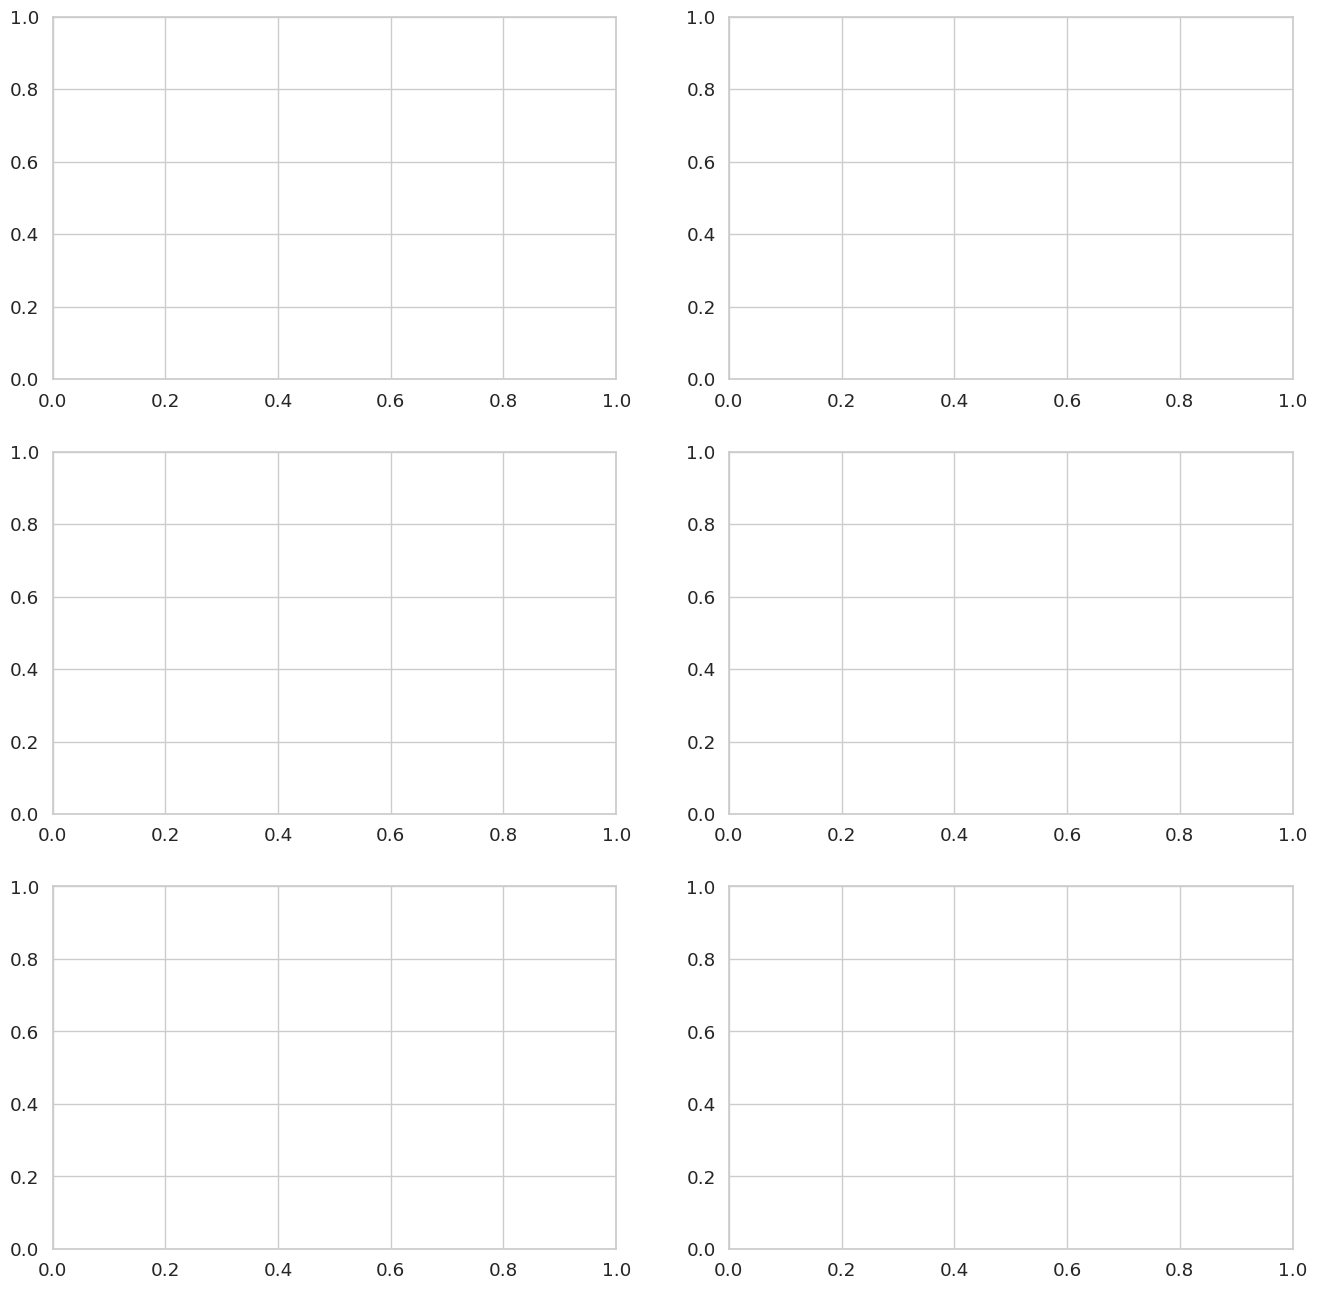

In [9]:
# 📁 src/tuning/visualize_search_results.py
# ➞ Heatmap visualization of R² scores across hidden_dim and learning rate combinations

# 📅 Load experiments log
log_path = "experiments/experiments_log.csv"
df_log = pd.read_csv(LOG_CSV_PATH)

# Современный стиль
sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

# Создаём 3×2 подграфика
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
axes = axes.flatten()

# Список параметров и названий
plot_params = [
    ("hidden_dim", "Hidden Dimensions"),
    ("lr", "Learning Rate"),
    ("batch_size", "Batch Size"),
    ("activation_fn", "Activation Function"),
    ("optimizer_name", "Optimizer")
]

# Строим графики
for i, (param, label) in enumerate(plot_params):
    ax = axes[i]
    sns.boxplot(x=param, y="R2", data=df_log, ax=ax, width=0.6, fliersize=2, linewidth=1.2)
    ax.set_title(f"R² Score by {label}", fontsize=14, fontweight='bold')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel("R² Score", fontsize=12)
    ax.xaxis.set_tick_params(rotation=30)

# Удаляем последний пустой subplot, если графиков меньше
if len(axes) > len(plot_params):
    fig.delaxes(axes[-1])

plt.tight_layout(pad=3)
plt.subplots_adjust(top=0.95)
fig.suptitle("Model Performance by Hyperparameters", fontsize=16, fontweight='bold')

plt.show()

# Выводим лучшую конфигурацию
best_row = df_log.loc[df_log["R2"].idxmax()]
print("\nBest Configuration:")
print(f"Run ID        : {best_row['run_id']}")
print(f"Hidden Dim    : {int(best_row['hidden_dim'])}")
print(f"Learning Rate : {best_row['lr']:.5f}")
print(f"Batch Size    : {int(best_row['batch_size'])}")
print(f"Activation Fn : {best_row['activation_fn']}")
print(f"Optimizer     : {best_row['optimizer_name']}")
print(f"R² Score      : {best_row['R2']:.4f}")
print(f"MAE           : {best_row['MAE']:.4f}")
print(f"MSE           : {best_row['MSE']:.6f}")

# ------------------------------
# 🔥 Heatmap of R² by hidden_dim × learning rate
# ------------------------------

# Группируем по hidden_dim и lr, берём среднее R²
pivot_table = df_log.pivot_table(
    values="R2",
    index="lr",         # строки — learning rate
    columns="hidden_dim",  # колонки — hidden_dim
    aggfunc="mean"
)

# Сортируем для лучшей читаемости
pivot_table = pivot_table.sort_index(ascending=False)

# Отрисовка
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "R² Score"})
plt.title("R² Heatmap: Hidden Dim × Learning Rate", fontsize=16, fontweight='bold')
plt.xlabel("Hidden Dim", fontsize=12)
plt.ylabel("Learning Rate", fontsize=12)
plt.tight_layout()
plt.show()

# ------------------------------
# 📊 Зона стабильных параметров по R²
# ------------------------------

# 1. Максимальное значение R²
r2_max = df_log["R2"].max()

# 2. Порог: 95% от максимума
threshold = r2_max * 0.95
print(f"\n R² threshold (95% of max): {threshold:.4f}")

# 3. Отбираем устойчиво хорошие параметры
stable_zone = df_log[df_log["R2"] >= threshold]
print(f"🔍 Found {len(stable_zone)} stable candidates:\n")

# 4. Выводим таблицу устойчивых параметров
print(stable_zone.sort_values("R2", ascending=False)[["hidden_dim", "lr", "batch_size", "activation_fn", "optimizer_name", "R2", "MAE", "MSE"]])
